# BigDL Bitcoin End‑to‑End Example
This interactive notebook shows **how to train a quick LSTM with BigDL** on recent BTC‑USD prices and explore the results with several visualisations.

Steps  
1. Run the ETL helper (download → clean → transform)  
2. Train a mini LSTM (few epochs – *demo‑only*)  
3. Predict the next 10 points  
4. Plot:
* Actual vs forecast (full window & zoom‑in)
* Rolling 24 h average vs price
* Distribution of pct‑change
* Rolling volatility (σ)
* Scatter of Δpct vs forecast error

---
⚠️ **Prerequisites**: you’ve already built the `bigdl‑bitcoin:latest` Docker image and launched Jupyter inside it, so Spark 3 + BigDL are on the path.

In [1]:
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta
from bigdl.dllib.utils.common import init_engine, Sample
from bigdl.dllib.nn.layer import Sequential, Reshape, Recurrent, LSTM, TimeDistributed, Linear, Select
from bigdl.dllib.nn.criterion import MSECriterion
from bigdl.dllib.optim.optimizer import Optimizer, Adam, MaxEpoch
from BigDL_API import (
    get_spark_session, fetch_bitcoin_prices, process_bitcoin_data,
    transform_bitcoin_data, load_bitcoin_data
)
plt.style.use('ggplot')
sns.set_theme()


/opt/conda/lib/python3.9/site-packages/bigdl/dllib/utils/engine.py:47: UserWarning: Find both SPARK_HOME and pyspark. You may need to check whether they match with each other. SPARK_HOME environment variable is set to: /usr/local/spark, and pyspark is found in: /opt/conda/lib/python3.9/site-packages/pyspark/__init__.py. If they are unmatched, please use one source only to avoid conflict. For example, you can unset SPARK_HOME and use pyspark only.
  warnings.warn(warning_msg)


In [2]:
# --- 1  ETL --------------------------------------------------------------
DAYS = 30  # ~1 month
OUTPUT_PATH = './output/bitcoin'
spark = get_spark_session()

raw_df = fetch_bitcoin_prices(days=DAYS)
clean_df = process_bitcoin_data(raw_df)
df = transform_bitcoin_data(clean_df)
load_bitcoin_data(df, OUTPUT_PATH)

print(df.printSchema())
df.show(5)


root
 |-- time: timestamp (nullable = true)
 |-- price: double (nullable = true)
 |-- rolling_avg_1h: double (nullable = true)
 |-- pct_change: double (nullable = true)

None
+-------------------+-----------------+-----------------+--------------------+
|               time|            price|   rolling_avg_1h|          pct_change|
+-------------------+-----------------+-----------------+--------------------+
|2025-04-25 07:00:20|93584.09278760613|93584.09278760613|                null|
|2025-04-25 08:03:34|93768.70443780805|93768.70443780805|  0.1972681945220109|
|2025-04-25 09:09:35|93672.32266122216|93672.32266122216|-0.10278672096809122|
|2025-04-25 10:04:41| 93826.3479104858|93749.33528585397| 0.16442983891910884|
|2025-04-25 11:02:51|93667.68760388183|93747.01775718381|  -0.169099949147905|
+-------------------+-----------------+-----------------+--------------------+
only showing top 5 rows



In [3]:
# --- 2  Train -----------------------------------------------------------
init_engine()
time_steps = 20
hidden = 64
epochs = 5

prices = df.select('price').rdd.map(lambda r: r[0]).collect()
scaler = MinMaxScaler().fit(np.array(prices).reshape(-1,1))
prices_scaled = scaler.transform(np.array(prices).reshape(-1,1)).flatten()

def make_seqs(series, steps):
    X, y = [], []
    for i in range(len(series)-steps):
        X.append(series[i:i+steps])
        y.append(series[i+steps])
    return np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

X, y = make_seqs(prices_scaled, time_steps)

# Build BigDL model
model = Sequential()
model.add(Reshape([time_steps, 1]))
model.add(Recurrent().add(LSTM(input_size=1, hidden_size=hidden)))
model.add(TimeDistributed(Linear(hidden, 1)))
model.add(Select(2, -1))

# Convert to Samples
samples = [Sample.from_ndarray(X[i].reshape(time_steps,1), np.array([y[i]])) for i in range(len(y))]
train_rdd = spark.sparkContext.parallelize(samples)

opt = Optimizer(model=model, training_rdd=train_rdd,
                criterion=MSECriterion(), optim_method=Adam(),
                batch_size=32, end_trigger=MaxEpoch(epochs))
trained_model = opt.optimize()


creating: createSequential
creating: createReshape
creating: createRecurrent
creating: createTanh
creating: createSigmoid
creating: createLSTM
creating: createLinear
creating: createTimeDistributed
creating: createSelect
creating: createMSECriterion
creating: createAdam
creating: createMaxEpoch
creating: createDistriOptimizer


/opt/conda/lib/python3.9/site-packages/bigdl/dllib/optim/optimizer.py:931: UserWarning: You are recommended to use `create` method to create an optimizer.
  warnings.warn("You are recommended to use `create` method to create an optimizer.")


In [4]:
# --- 3  Forecast --------------------------------------------------------
def forecast(model, scaler, recent, steps=10):
    seq = scaler.transform(np.array(recent).reshape(-1,1)).flatten().tolist()
    preds = []
    for _ in range(steps):
        arr = np.array(seq, dtype=np.float32).reshape(1,len(seq),1)
        pred_scaled = float(model.predict(arr).squeeze())
        pred_real = scaler.inverse_transform([[pred_scaled]])[0][0]
        preds.append(pred_real)
        seq = seq[1:] + [pred_scaled]
    return preds

recent_raw = prices[-time_steps:]
future_preds = forecast(trained_model, scaler, recent_raw, steps=10)
future_preds


[108830.1574960318,
 108866.34073160296,
 108962.01845236939,
 109061.72975463832,
 109157.24469518824,
 109247.93123773031,
 109333.43014316604,
 109413.77509016093,
 109489.25234737154,
 109559.91243279612]

/opt/conda/lib/python3.9/site-packages/pyspark/sql/pandas/conversion.py:178: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


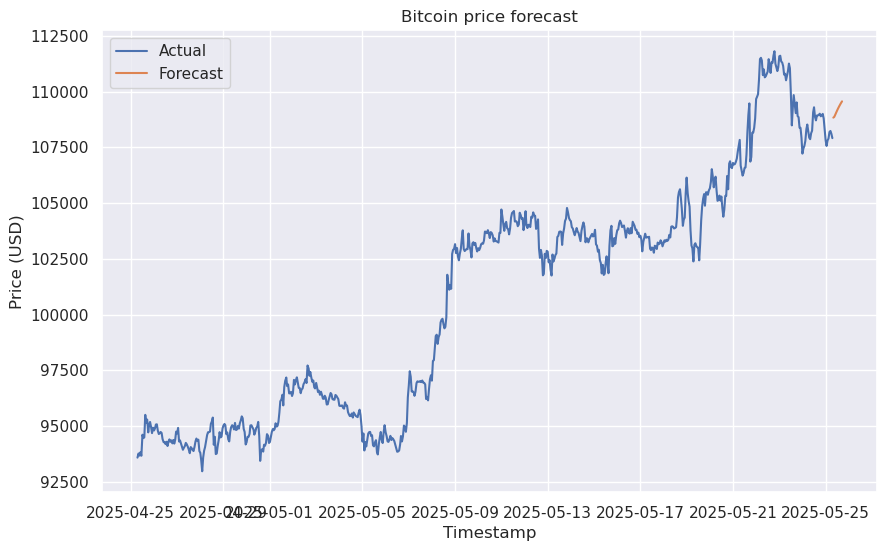

In [7]:
# --- 4  Visuals ---------------------------------------------------------
pdf = df.toPandas()

# 4.1  Actual vs forecast (full window)
future_times = pd.date_range(start=pdf['time'].iloc[-1], periods=len(future_preds)+1, freq='H')[1:]
plt.figure(figsize=(10,6))
plt.plot(pdf['time'], pdf['price'], label='Actual')
plt.plot(future_times, future_preds, label='Forecast')
plt.title('Bitcoin price forecast')
plt.xlabel('Timestamp'); plt.ylabel('Price (USD)'); plt.legend(); plt.show()


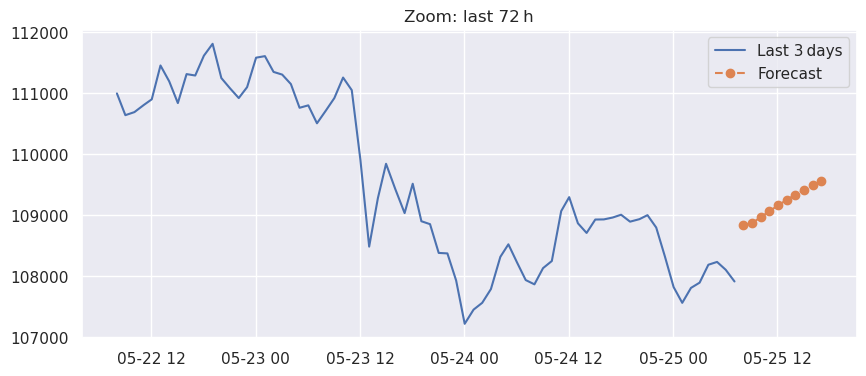

In [8]:
# 4.2  Zoom‑in last 3 days
plt.figure(figsize=(10,4))
last_window = pdf[pdf['time'] >= pdf['time'].iloc[-1]-pd.Timedelta(days=3)]
plt.plot(last_window['time'], last_window['price'], label='Last 3 days')
plt.plot(future_times, future_preds, 'o--', label='Forecast')
plt.title('Zoom: last 72 h'); plt.legend(); plt.show()


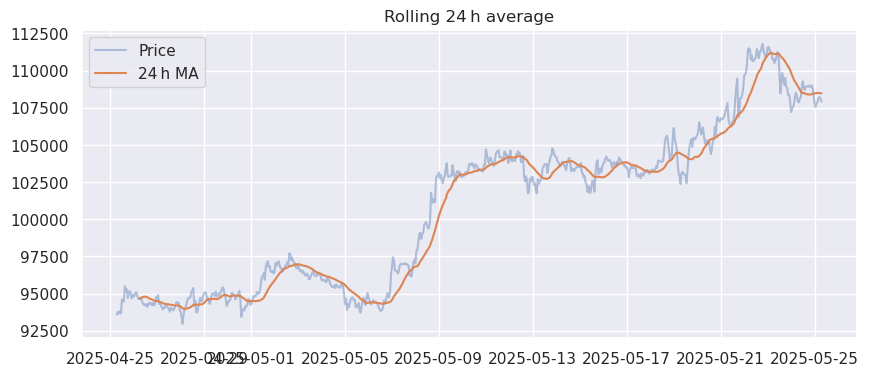

In [9]:
# 4.3  24h rolling mean
pdf['roll24'] = pdf['price'].rolling(24).mean()
plt.figure(figsize=(10,4))
plt.plot(pdf['time'], pdf['price'], alpha=0.4, label='Price')
plt.plot(pdf['time'], pdf['roll24'], label='24 h MA')
plt.title('Rolling 24 h average'); plt.legend(); plt.show()

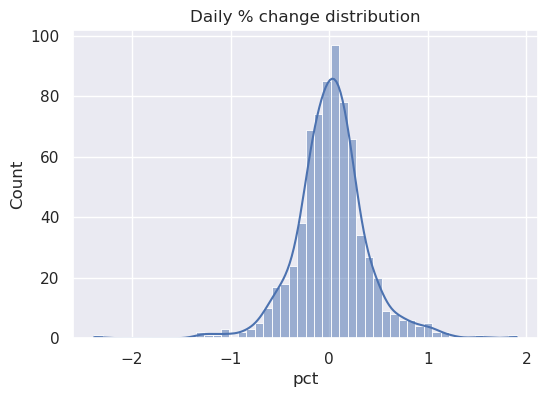

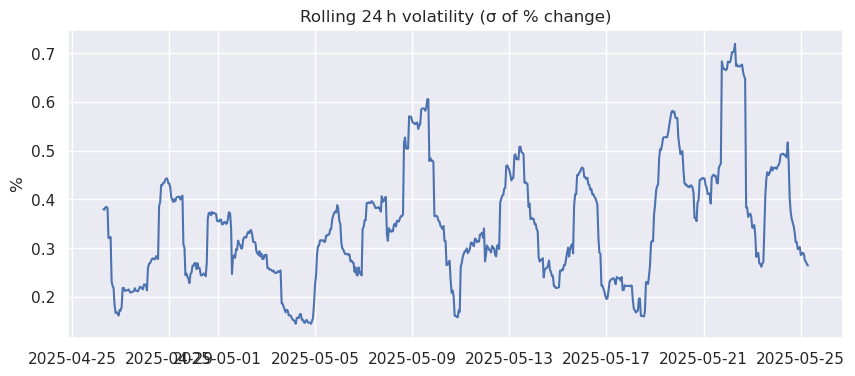

In [10]:
# 4.4  pct‑change distribution & volatility
pdf['pct'] = pdf['price'].pct_change()*100
plt.figure(figsize=(6,4))
sns.histplot(pdf['pct'].dropna(), bins=50, kde=True)
plt.title('Daily % change distribution'); plt.show()

pdf['vol24'] = pdf['pct'].rolling(24).std()
plt.figure(figsize=(10,4))
plt.plot(pdf['time'], pdf['vol24'])
plt.title('Rolling 24 h volatility (σ of % change)'); plt.ylabel('%'); plt.show()